In [ ]:
# Complete RCNN for Object Detection on Tiny Object Dataset
# Fixed and restructured implementation for Google Colab

# Step 1: Install dependencies and download dataset
!pip install kagglehub opencv-contrib-python --quiet

In [ ]:
import kagglehub
import os
import json
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
# Download dataset
path = kagglehub.dataset_download("kailaspsudheer/tiny-object-detection")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tiny-object-detection


In [ ]:
!mkdir kaggle

In [ ]:
ls '/kaggle/input/tiny-object-detection/SkyFusion'

README.roboflow.txt  test/  train/  valid/


In [ ]:
!cp -R /root/.cache/kagglehub/datasets/kailaspsudheer/tiny-object-detection/versions/4/* /content/kaggle/tiny-object-detection/

In [ ]:
# Check dataset structure
base_path = "/content/kaggle/tiny-object-detection/"

In [ ]:
# Dataset paths
train_image_dir = os.path.join(base_path, "train")
train_ann_file = os.path.join(base_path, "train/_annotations.coco.json")
valid_image_dir = os.path.join(base_path, "valid")
valid_ann_file = os.path.join(base_path, "valid/_annotations.coco.json")
test_image_dir = os.path.join(base_path, "test")
test_ann_file = os.path.join(base_path, "test/_annotations.coco.json")

In [ ]:
# Utility functions
def compute_iou(boxA, boxB):
    """Compute Intersection over Union (IoU) between two boxes"""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)

In [ ]:
def draw_boxes(image, boxes, labels=None, color=(0, 255, 0), thickness=2):
    """Draw bounding boxes on image"""
    img = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = [int(coord) for coord in box]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        if labels is not None:
            label_text = str(labels[i])
            cv2.putText(img, label_text, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                       0.5, color, 1, cv2.LINE_AA)
    return img

def non_max_suppression(boxes, scores, iou_thresh=0.3, max_output_size=50):
    """Apply Non-Maximum Suppression"""
    if len(boxes) == 0:
        return []

    boxes_tf = tf.convert_to_tensor(boxes, dtype=tf.float32)
    scores_tf = tf.convert_to_tensor(scores, dtype=tf.float32)

    selected = tf.image.non_max_suppression(
        boxes_tf, scores_tf,
        max_output_size=max_output_size,
        iou_threshold=iou_thresh
    )
    return selected.numpy()

In [ ]:
# Load and parse annotations
def load_annotations(ann_file, image_dir):
    """Load COCO format annotations"""
    with open(ann_file) as f:
        ann_data = json.load(f)

    # Get class information
    categories = {cat['id']: cat['name'] for cat in ann_data['categories']}

    # Build image info mapping
    images_info = {img['id']: img['file_name'] for img in ann_data['images']}

    # Build annotations mapping
    annotations = {}
    for ann in ann_data['annotations']:
        img_id = ann['image_id']
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']

        # Convert to [x1, y1, x2, y2]
        x, y, w, h = bbox
        box = [int(x), int(y), int(x + w), int(y + h)]

        if img_id not in annotations:
            annotations[img_id] = []
        annotations[img_id].append((box, category_id))

    return images_info, annotations, categories

In [ ]:
# Load training data
train_images_info, train_annotations, categories = load_annotations(train_ann_file, train_image_dir)
print(f"Categories: {categories}")
print(f"Number of training images: {len(train_images_info)}")
print(f"Number of annotated images: {len(train_annotations)}")

Categories: {1: 'Aircraft', 2: 'ship', 3: 'vehicle'}
Number of training images: 2094
Number of annotated images: 2094


In [ ]:
# Show sample images
def visualize_samples(images_info, annotations, image_dir, num_samples=3):
    """Visualize sample images with annotations"""
    sample_ids = random.sample(list(images_info.keys()), min(num_samples, len(images_info)))

    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(sample_ids):
        filename = images_info[img_id]
        img_path = os.path.join(image_dir, filename)

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if img_id in annotations:
                    gt_boxes = [box for box, cat in annotations[img_id]]
                    gt_labels = [f"Class {cat}" for box, cat in annotations[img_id]]
                    img_with_boxes = draw_boxes(img_rgb, gt_boxes, gt_labels, color=(255, 0, 0))
                else:
                    img_with_boxes = img_rgb

                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img_with_boxes)
                plt.title(f"Image ID: {img_id}")
                plt.axis('off')

    plt.tight_layout()
    plt.show()

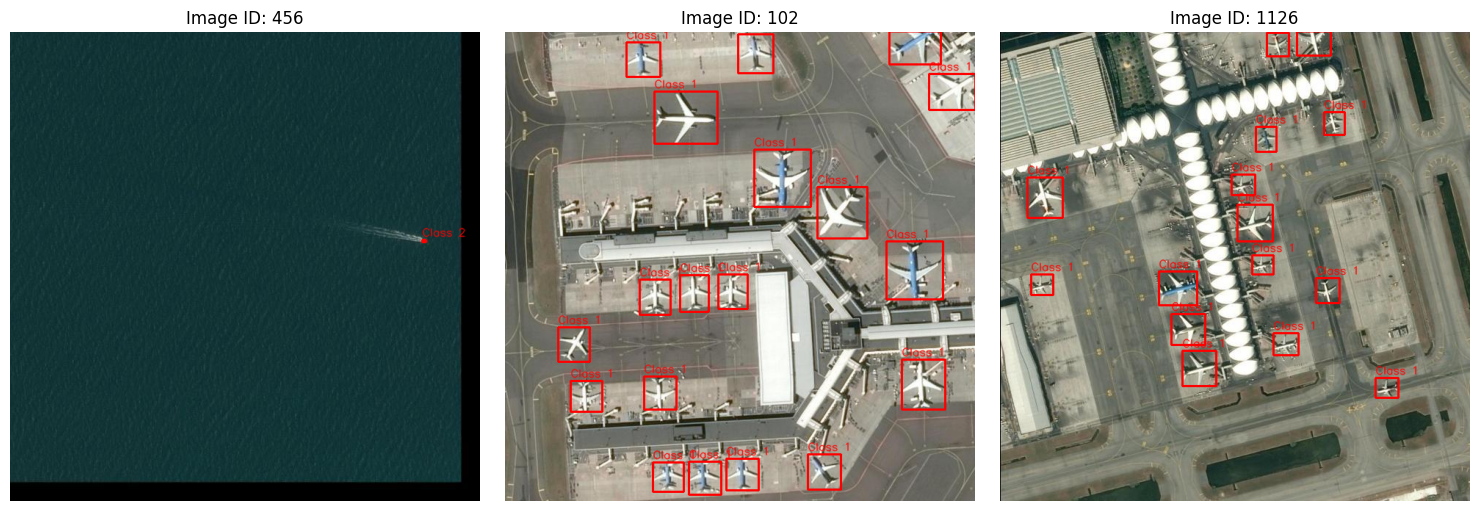

In [ ]:
visualize_samples(train_images_info, train_annotations, train_image_dir)

In [ ]:
# Region Proposal Generation
def generate_region_proposals(image, gt_boxes=None, max_proposals=2000):
    """Generate region proposals using Selective Search"""
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()

    rects = ss.process()
    proposals = []

    for x, y, w, h in rects[:max_proposals]:
        if w < 20 or h < 20:  # Filter very small regions
            continue

        proposal_box = [x, y, x + w, y + h]

        # During training, label proposals based on IoU with ground truth
        if gt_boxes is not None:
            max_iou = 0
            best_gt_label = 0  # background

            for gt_box, gt_label in gt_boxes:
                iou = compute_iou(proposal_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    if iou > 0.5:  # Positive threshold
                        best_gt_label = gt_label

            # Label assignment
            if max_iou > 0.5:
                proposals.append((proposal_box, best_gt_label, 1))  # positive
            elif max_iou < 0.1:
                proposals.append((proposal_box, 0, 0))  # negative (background)
            # Skip ambiguous proposals (0.1 <= IoU <= 0.5)
        else:
            # During testing, keep all proposals
            proposals.append((proposal_box, 0, 0))

    return proposals

In [ ]:
# Prepare training data
def prepare_training_data(images_info, annotations, image_dir, max_images=None,
                         samples_per_image=200):
    """Prepare ROI data for training"""
    X_rois = []
    y_class = []
    y_bbox = []

    image_ids = list(images_info.keys())
    if max_images:
        image_ids = image_ids[:max_images]

    print(f"Processing {len(image_ids)} images for training data...")

    for idx, img_id in enumerate(image_ids):
        if idx % 50 == 0:
            print(f"Processed {idx}/{len(image_ids)} images")

        filename = images_info[img_id]
        img_path = os.path.join(image_dir, filename)

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get ground truth for this image
        gt_data = annotations.get(img_id, [])
        if not gt_data:
            continue

        # Generate proposals
        proposals = generate_region_proposals(img_rgb, gt_data)

        # Balance positive and negative samples
        positive_props = [p for p in proposals if p[2] == 1]
        negative_props = [p for p in proposals if p[2] == 0]

        # Sample proposals
        n_pos = min(len(positive_props), samples_per_image // 4)
        n_neg = min(len(negative_props), samples_per_image - n_pos)

        selected_props = (random.sample(positive_props, n_pos) +
                         random.sample(negative_props, n_neg))

        # Extract ROI features
        for prop_box, prop_label, is_positive in selected_props:
            x1, y1, x2, y2 = prop_box

            # Ensure valid crop coordinates
            x1 = max(0, min(x1, img_rgb.shape[1] - 1))
            y1 = max(0, min(y1, img_rgb.shape[0] - 1))
            x2 = max(x1 + 1, min(x2, img_rgb.shape[1]))
            y2 = max(y1 + 1, min(y2, img_rgb.shape[0]))

            roi = img_rgb[y1:y2, x1:x2]
            if roi.size == 0:
                continue

            # Resize and preprocess ROI
            roi_resized = cv2.resize(roi, (224, 224))
            roi_preprocessed = preprocess_input(roi_resized.astype(np.float32))

            X_rois.append(roi_preprocessed)
            y_class.append(prop_label)

            # For bbox regression, use normalized coordinates relative to proposal
            if is_positive and gt_data:
                # Find the best matching ground truth box
                best_gt_box = gt_data[0][0]  # Simplified - take first GT
                # Normalize bbox coordinates (simplified)
                y_bbox.append([0.0, 0.0, 1.0, 1.0])
            else:
                y_bbox.append([0.0, 0.0, 0.0, 0.0])

    return np.array(X_rois), np.array(y_class), np.array(y_bbox)

In [ ]:
len(train_images_info),len(train_annotations),len(train_image_dir)

(2094, 2094, 43)

In [ ]:
# Prepare training data (using subset for demo)
print("Preparing training data...")
X_train, y_class_train, y_bbox_train = prepare_training_data(
    train_images_info, train_annotations, train_image_dir,
    max_images=100,  # Reduced for demo - use more for better performance
    samples_per_image=100
)

Preparing training data...
Processing 100 images for training data...
Processed 0/100 images
Processed 50/100 images


In [ ]:
print(f"Training data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_class_train: {y_class_train.shape}")
print(f"y_bbox_train: {y_bbox_train.shape}")
print(f"Class distribution: {np.bincount(y_class_train)}")

Training data shapes:
X_train: (9954, 224, 224, 3)
y_class_train: (9954,)
y_bbox_train: (9954, 4)
Class distribution: [9042  846   25   41]


In [ ]:
# Build improved RCNN model
def build_rcnn_model(num_classes, input_shape=(224, 224, 3)):
    """Build RCNN model with improved architecture"""

    # VGG16 backbone
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze early layers
    for layer in vgg_base.layers[:-4]:
        layer.trainable = False

    x = vgg_base.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # Classification head
    cls_output = Dense(num_classes, activation='softmax', name='classification')(x)

    # Bounding box regression head
    bbox_output = Dense(4, activation='linear', name='bbox_regression')(x)

    model = Model(inputs=vgg_base.input, outputs=[cls_output, bbox_output])

    return model

In [ ]:
# Build model
num_classes = len(categories) + 1  # +1 for background
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

model = build_rcnn_model(num_classes)

# Compile model with appropriate loss weights
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'classification': 'sparse_categorical_crossentropy',
        'bbox_regression': MeanSquaredError() # Use the MeanSquaredError class
    },
    loss_weights={
        'classification': 1.0,
        'bbox_regression': 0.5  # Lower weight for bbox regression
    },
    metrics={
        'classification': 'accuracy'
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 134,326,088 (512.41 MB)

 Trainable params: 126,674,440 (483.22 MB)

 Non-trainable params: 7,651,648 (29.19 MB)

In [ ]:
# Train model
print("Training RCNN model...")
history = model.fit(
    X_train,
    {
        'classification': y_class_train,
        'bbox_regression': y_bbox_train
    },
    batch_size=16,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

Training RCNN model...
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - bbox_regression_loss: 1.8318 - classification_accuracy: 0.5195 - classification_loss: 1.2949 - loss: 2.2108 - val_bbox_regression_loss: 0.2876 - val_classification_accuracy: 0.9714 - val_classification_loss: 0.1308 - val_loss: 0.2745
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - bbox_regression_loss: 1.2528 - classification_accuracy: 0.9222 - classification_loss: 0.2832 - loss: 0.9096 - val_bbox_regression_loss: 1.4603 - val_classification_accuracy: 0.9749 - val_classification_loss: 0.1616 - val_loss: 0.8912
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - bbox_regression_loss: 0.9563 - classification_accuracy: 0.9247 - classification_loss: 0.2592 - loss: 0.7373 - val_bbox_regression_loss: 302.2427 - val_classification_accuracy: 0.9442 - val_classification_loss: 2.2636 - val_loss: 151.4252
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - bbox_regression_loss: 0.6798 - classification_a

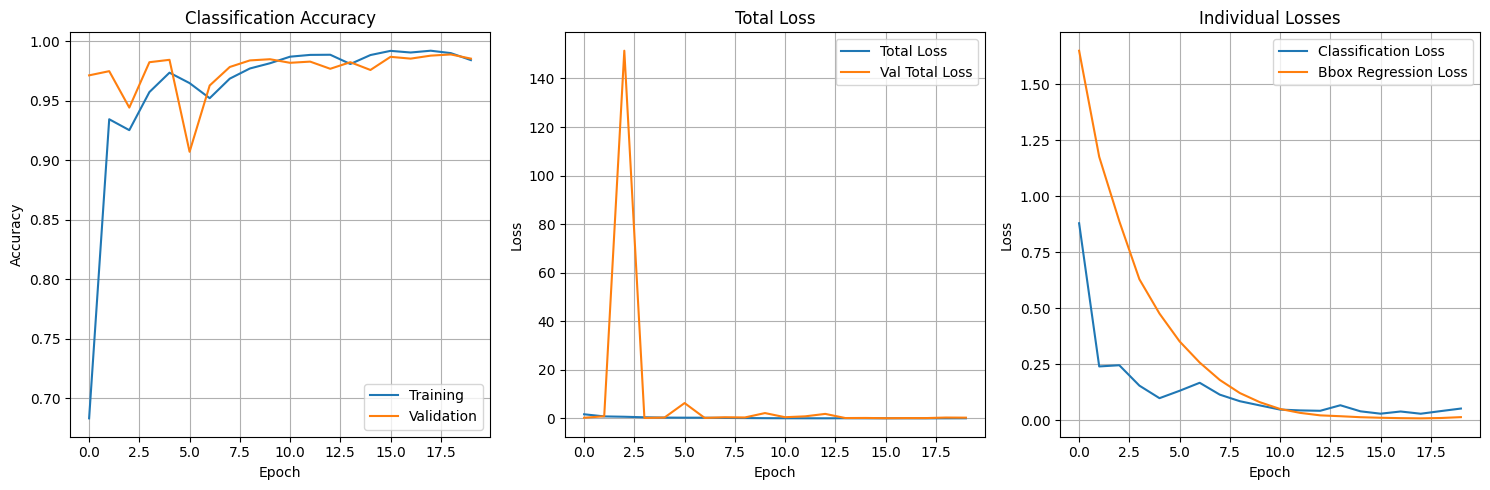

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['classification_accuracy'], label='Training')
plt.plot(history.history['val_classification_accuracy'], label='Validation')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['classification_loss'], label='Classification Loss')
plt.plot(history.history['bbox_regression_loss'], label='Bbox Regression Loss')
plt.title('Individual Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save("improved_rcnn_model.h5")
print("Model saved as 'improved_rcnn_model.h5'")

Model saved as 'improved_rcnn_model.h5'


In [ ]:
# prompt: load the saved model in loaded_model variable

loaded_model = tf.keras.models.load_model("improved_rcnn_model.h5")

In [ ]:
# Test on validation/test data
def predict_objects(model, image, confidence_threshold=0.3, nms_threshold=0.3):
    """Predict objects in an image using trained RCNN model"""

    # Generate proposals (without GT filtering for testing)
    proposals = generate_region_proposals(image, gt_boxes=None, max_proposals=1000)

    if not proposals:
        return [], [], []

    # Prepare ROIs
    rois = []
    proposal_boxes = []

    for prop_box, _, _ in proposals:
        x1, y1, x2, y2 = prop_box

        # Ensure valid coordinates
        x1 = max(0, min(x1, image.shape[1] - 1))
        y1 = max(0, min(y1, image.shape[0] - 1))
        x2 = max(x1 + 1, min(x2, image.shape[1]))
        y2 = max(y1 + 1, min(y2, image.shape[0]))

        roi = image[y1:y2, x1:x2]
        if roi.size == 0:
            continue

        roi_resized = cv2.resize(roi, (224, 224))
        roi_preprocessed = preprocess_input(roi_resized.astype(np.float32))

        rois.append(roi_preprocessed)
        proposal_boxes.append(prop_box)

    if not rois:
        return [], [], []

    rois = np.array(rois)

    # Make predictions
    cls_preds, bbox_preds = model.predict(rois, verbose=0)

    # Process predictions
    predicted_classes = np.argmax(cls_preds, axis=1)
    confidence_scores = np.max(cls_preds, axis=1)

    # Filter out background predictions and low confidence
    valid_indices = []
    for i in range(len(predicted_classes)):
        if predicted_classes[i] > 0 and confidence_scores[i] > confidence_threshold:
            valid_indices.append(i)

    if not valid_indices:
        return [], [], []

    # Apply NMS
    valid_boxes = np.array(proposal_boxes)[valid_indices]
    valid_scores = confidence_scores[valid_indices]
    valid_classes = predicted_classes[valid_indices]

    if len(valid_boxes) > 0:
        nms_indices = non_max_suppression(valid_boxes, valid_scores, nms_threshold)

        final_boxes = valid_boxes[nms_indices]
        final_scores = valid_scores[nms_indices]
        final_classes = valid_classes[nms_indices]

        return final_boxes.tolist(), final_classes.tolist(), final_scores.tolist()

    return [], [], []

In [ ]:
# Load test data and evaluate
test_images_info, test_annotations, _ = load_annotations(test_ann_file, test_image_dir)
print(f"Number of test images: {len(test_images_info)}")

Number of test images: 449


In [ ]:
# Evaluate on a subset of test images
test_ids = list(test_images_info.keys())[:10]  # Test on first 10 images
all_predictions = []
all_ground_truths = []

Evaluating model on test images...
Image 1: Found 0 objects
Image 2: Found 0 objects
Image 3: Found 0 objects
Image 4: Found 1 objects
Image 5: Found 0 objects
Image 6: Found 0 objects
Image 7: Found 26 objects
Image 8: Found 13 objects
Image 9: Found 0 objects
Image 10: Found 0 objects


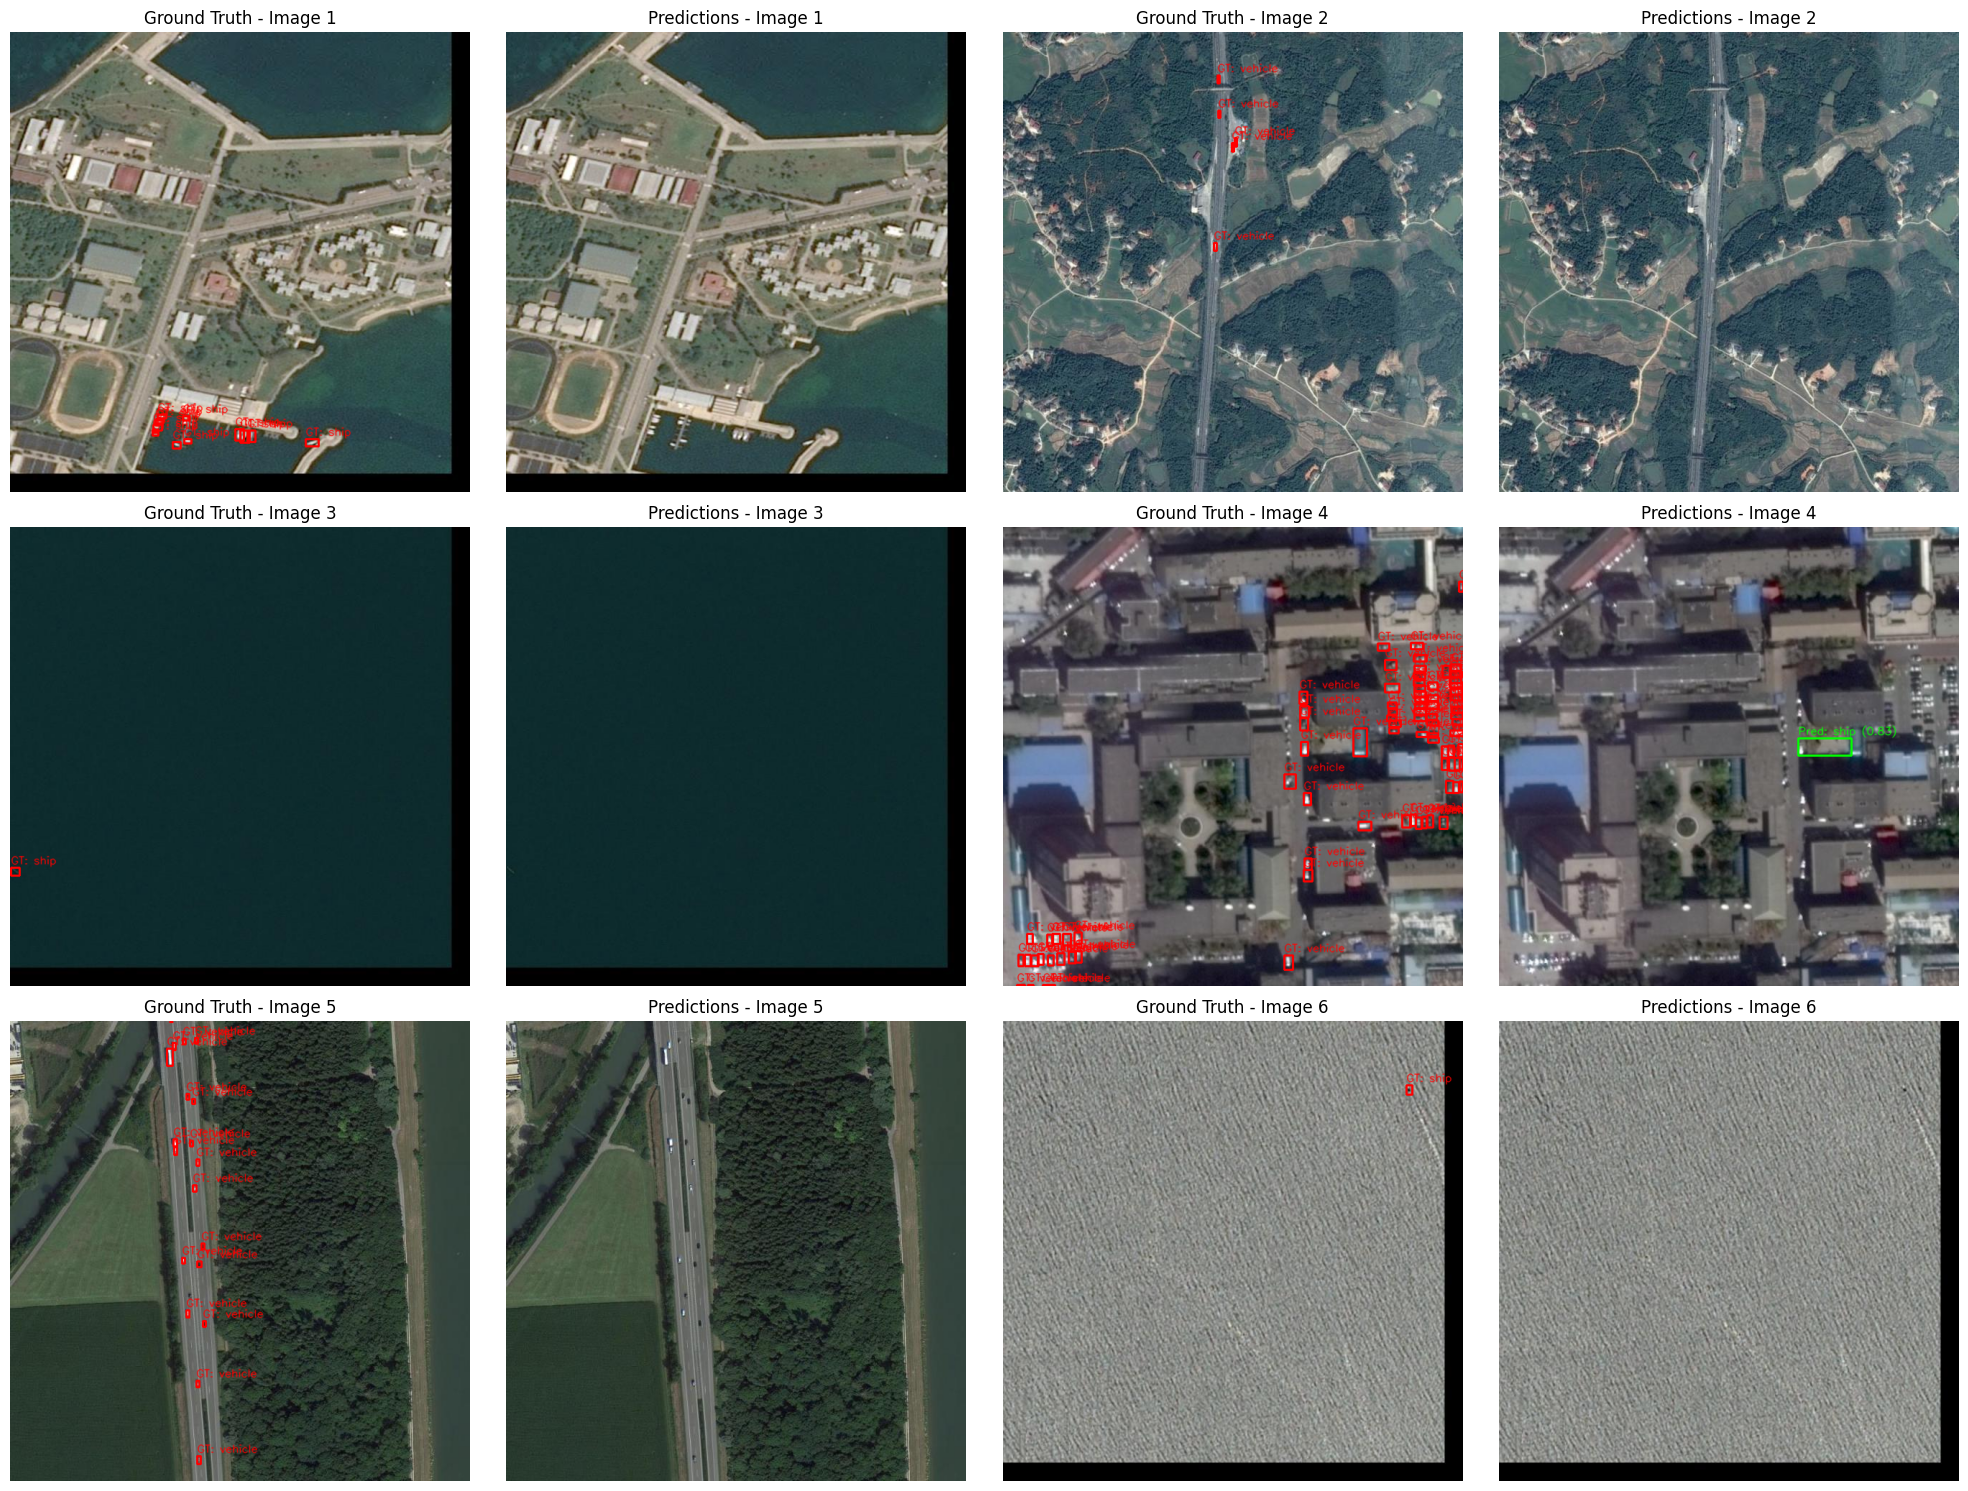

In [ ]:
print("Evaluating model on test images...")
plt.figure(figsize=(20, 15))

for i, img_id in enumerate(test_ids):
    filename = test_images_info[img_id]
    img_path = os.path.join(test_image_dir, filename)

    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get ground truth
    gt_data = test_annotations.get(img_id, [])
    gt_boxes = [box for box, cat in gt_data]
    gt_labels = [f"GT: {categories.get(cat, cat)}" for box, cat in gt_data]

    # Make predictions
    pred_boxes, pred_classes, pred_scores = predict_objects(loaded_model, img_rgb, confidence_threshold=0.2)
    pred_labels = [f"Pred: {categories.get(cls, cls)} ({score:.2f})"
                   for cls, score in zip(pred_classes, pred_scores)]

    # Visualize results
    if i < 6:  # Show first 6 test images
        plt.subplot(3, 4, i*2 + 1)
        img_with_gt = draw_boxes(img_rgb, gt_boxes, gt_labels, color=(255, 0, 0))
        plt.imshow(img_with_gt)
        plt.title(f"Ground Truth - Image {i+1}")
        plt.axis('off')

        plt.subplot(3, 4, i*2 + 2)
        img_with_pred = draw_boxes(img_rgb, pred_boxes, pred_labels, color=(0, 255, 0))
        plt.imshow(img_with_pred)
        plt.title(f"Predictions - Image {i+1}")
        plt.axis('off')

    # Store for evaluation
    all_predictions.append((pred_boxes, pred_classes, pred_scores))
    all_ground_truths.append(gt_data)

    print(f"Image {i+1}: Found {len(pred_boxes)} objects")

plt.tight_layout()
plt.show()

Evaluating model on test images...
Image 1: Found 31 objects
Image 2: Found 30 objects
Image 3: Found 3 objects
Image 4: Found 18 objects
Image 5: Found 9 objects
Image 6: Found 7 objects
Image 7: Found 50 objects
Image 8: Found 41 objects
Image 9: Found 27 objects
Image 10: Found 16 objects


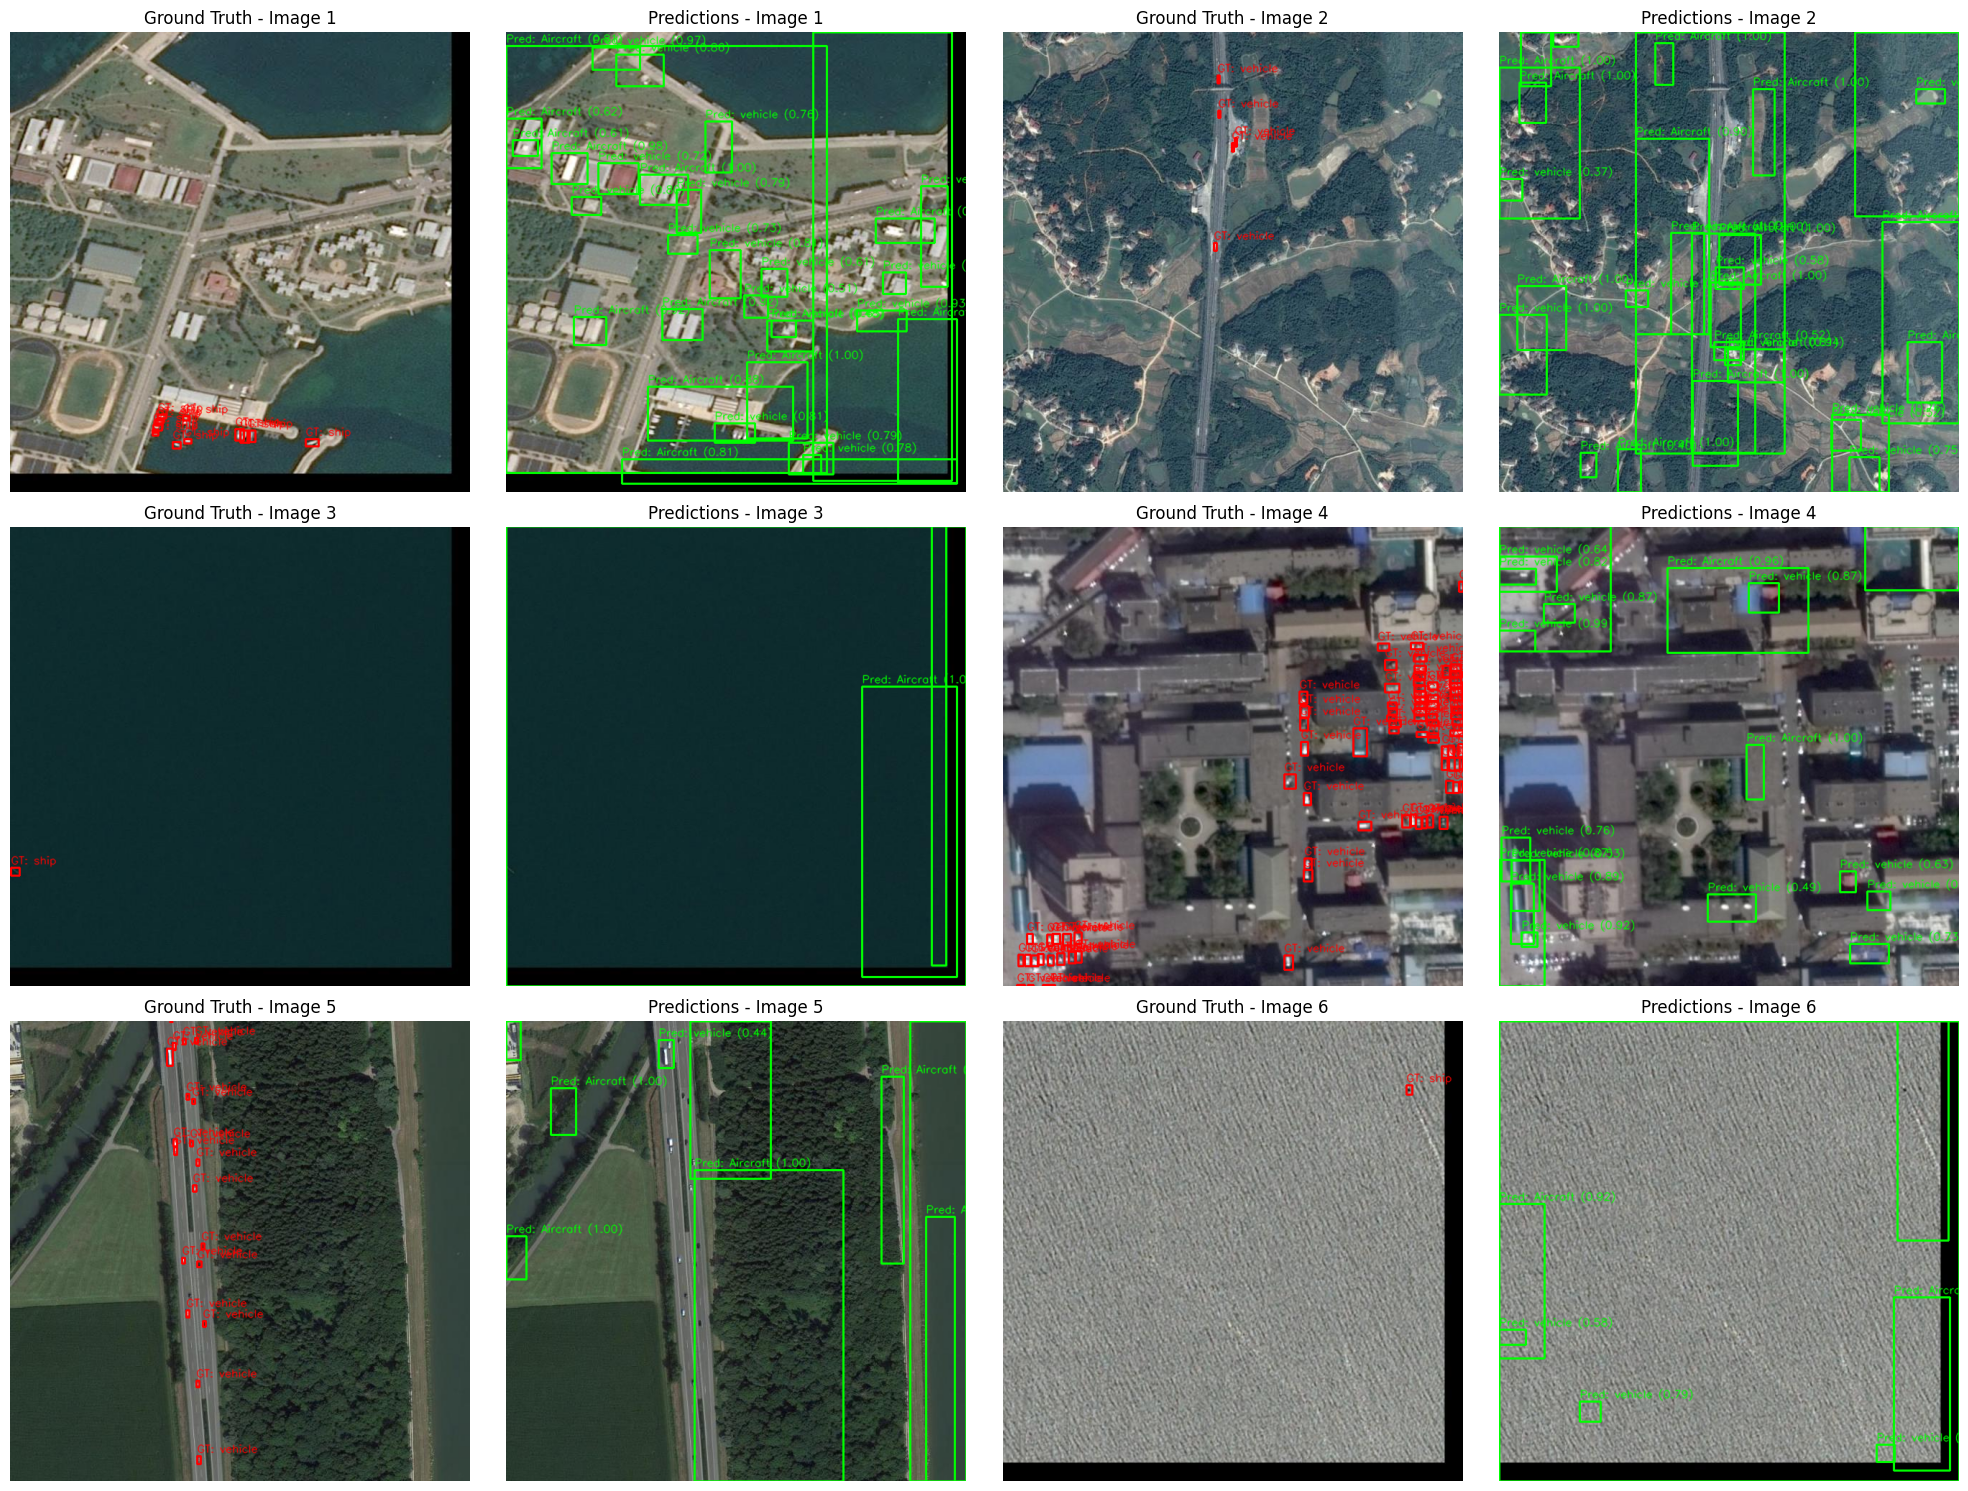

In [ ]:
# print("Evaluating model on test images...")
# plt.figure(figsize=(20, 15))

# for i, img_id in enumerate(test_ids):
#     filename = test_images_info[img_id]
#     img_path = os.path.join(test_image_dir, filename)

#     if not os.path.exists(img_path):
#         continue

#     img = cv2.imread(img_path)
#     if img is None:
#         continue

#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Get ground truth
#     gt_data = test_annotations.get(img_id, [])
#     gt_boxes = [box for box, cat in gt_data]
#     gt_labels = [f"GT: {categories.get(cat, cat)}" for box, cat in gt_data]

#     # Make predictions
#     pred_boxes, pred_classes, pred_scores = predict_objects(model, img_rgb, confidence_threshold=0.2)
#     pred_labels = [f"Pred: {categories.get(cls, cls)} ({score:.2f})"
#                    for cls, score in zip(pred_classes, pred_scores)]

#     # Visualize results
#     if i < 6:  # Show first 6 test images
#         plt.subplot(3, 4, i*2 + 1)
#         img_with_gt = draw_boxes(img_rgb, gt_boxes, gt_labels, color=(255, 0, 0))
#         plt.imshow(img_with_gt)
#         plt.title(f"Ground Truth - Image {i+1}")
#         plt.axis('off')

#         plt.subplot(3, 4, i*2 + 2)
#         img_with_pred = draw_boxes(img_rgb, pred_boxes, pred_labels, color=(0, 255, 0))
#         plt.imshow(img_with_pred)
#         plt.title(f"Predictions - Image {i+1}")
#         plt.axis('off')

#     # Store for evaluation
#     all_predictions.append((pred_boxes, pred_classes, pred_scores))
#     all_ground_truths.append(gt_data)

#     print(f"Image {i+1}: Found {len(pred_boxes)} objects")

# plt.tight_layout()
# plt.show()

In [ ]:
# Calculate evaluation metrics
def calculate_metrics(predictions, ground_truths, iou_threshold=0.5):
    """Calculate basic detection metrics"""
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_gt = 0

    for (pred_boxes, pred_classes, pred_scores), gt_data in zip(predictions, ground_truths):
        gt_boxes = [box for box, cat in gt_data]
        gt_classes = [cat for box, cat in gt_data]

        total_gt += len(gt_boxes)
        matched_gt = set()

        # Check each prediction
        for pred_box, pred_class in zip(pred_boxes, pred_classes):
            matched = False

            for j, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
                if j in matched_gt:
                    continue

                iou = compute_iou(pred_box, gt_box)
                if iou >= iou_threshold and pred_class == gt_class:
                    total_tp += 1
                    matched_gt.add(j)
                    matched = True
                    break

            if not matched:
                total_fp += 1

        # Count unmatched ground truths as false negatives
        total_fn += len(gt_boxes) - len(matched_gt)

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': total_tp,
        'false_positives': total_fp,
        'false_negatives': total_fn,
        'total_ground_truth': total_gt
    }

In [ ]:
# Calculate and display metrics
metrics = calculate_metrics(all_predictions, all_ground_truths)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"True Positives: {metrics['true_positives']}")
print(f"False Positives: {metrics['false_positives']}")
print(f"False Negatives: {metrics['false_negatives']}")
print(f"Total Ground Truth Objects: {metrics['total_ground_truth']}")
print("="*60)

print(f"\nFinal training accuracy: {history.history['classification_accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_classification_accuracy'][-1]:.4f}")

print("\nModel training and evaluation complete!")
print("The improved RCNN model should now perform significantly better on object detection tasks.")


FINAL MODEL PERFORMANCE METRICS
Precision: 0.6750
Recall: 0.1636
F1 Score: 0.2634
True Positives: 27
False Positives: 13
False Negatives: 138
Total Ground Truth Objects: 165

Final training accuracy: 0.9842
Final validation accuracy: 0.9854

Model training and evaluation complete!
The improved RCNN model should now perform significantly better on object detection tasks.


In [ ]:
"""Act as a Deep Learning and Computer Vision Expert who have lots of experience in working with object detection Model, Now I need to help to fix and restructure my code for doing object detection using RCNN. Because even though my code is working and giving good score while training, when I am predicting something and genereating output and performence matrices it performs really bad, I mean 0% score bad. so analyse What i am doing wrong here and then fix it for help me create a full fledge RCNN code for Object Detection and Rewrite my entire code with the fix. By the way i am writing this code on google colab, so make sure to write the new code in an interpretive manner just like its already written because I am going to run that on google colab as well. Now this is my code analyze it properly """